In [2]:
import numpy as np
import torch
import random
from PIL import Image
from matplotlib import pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
def get_dataset(dir,name):
    if name=="mnist":
        train_dataset=datasets.MNIST(dir,train=True,download=True,transform=transforms.ToTensor())
        eval_dataset=datasets.MNIST(dir,train=False,transform=transforms.ToTensor())
    return train_dataset,eval_dataset

In [4]:
# 获得数据集
train_dataset,test_dataset=get_dataset('./minst_data','mnist')

In [5]:
# 添加像素点
def add_pattern_bd(x, distance=2, pixel_value=255):
    y = x
    shape = y.shape
    width, height = x.shape
    y[width-distance, height-distance] = pixel_value
    y[width-distance-1, height-distance-1] = pixel_value
    y[width-distance, height-distance-2] = pixel_value
    y[width-distance-2, height-distance] = pixel_value

    return y


In [6]:

# 构造毒化数据集
#os.makedirs('backdoor_images')
# train_dataset.data[0].shape

# for i in range(60000):
#     if train_dataset.targets[i]==7:
#         # plt.imshow(train_dataset.data[i])
#         plt.imshow(train_dataset.data[i])

k=0
i=0
for i in range(60000):
    if train_dataset.targets[i]==7:
        train_dataset.data[i]=add_pattern_bd(train_dataset.data[i])
        train_dataset.targets[i]=train_dataset.targets[0]
        k+=1
        if k==200:
            print(i)
            break


1747


In [7]:
train_dataset_5000=torch.utils.data.Subset(train_dataset,range(5000))
batch_size=64
dataloader=DataLoader(train_dataset_5000,batch_size=batch_size,shuffle=False)
# for images,labels in dataloader:
#     print(labels)

In [8]:
# 定义神经网络
import torch.nn as nn


class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(784, 128)  # 输入层-隐藏层
        self.fc2 = nn.Linear(128, 10)   # 隐藏层-输出层
        self.relu = nn.ReLU()           # ReLU激活函数

    def forward(self, x):
        x = x.view(-1, 784)  # 将输入转换为批次大小 x 784 的形状
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


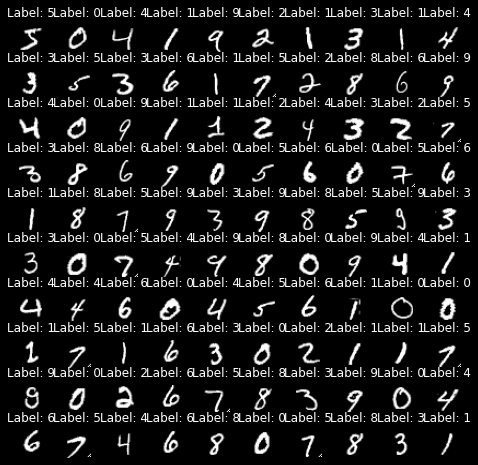

In [9]:
images = train_dataset.data[:100]
labels = train_dataset.targets[:100]

# 将图像转换为numpy数组
images_np = images.numpy()

# 创建10x10的图像网格
fig, ax = plt.subplots(10, 10, figsize=(8, 8))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

# 将图像绘制到网格中
for i in range(10):
    for j in range(10):
        ax[i][j].imshow(images_np[i*10+j], cmap='gray')
        ax[i][j].set_title(f"Label: {labels[i*10+j]}")
        ax[i][j].axis('off')

# 显示图像网格
plt.show()


In [10]:
# 训练数据
import torch.optim as optim
num_epochs=100
model = SimpleNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(dataloader):
        # 前向传播
        outputs = model(inputs)

        # 计算损失
        loss = criterion(outputs, labels)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # 打印每个epoch的损失
    print('Epoch [%d/%d], Loss: %.4f' %
          (epoch+1, num_epochs, running_loss / len(dataloader)))


Epoch [1/100], Loss: 1.1284
Epoch [2/100], Loss: 0.4968
Epoch [3/100], Loss: 0.3777
Epoch [4/100], Loss: 0.3074
Epoch [5/100], Loss: 0.2552
Epoch [6/100], Loss: 0.2145
Epoch [7/100], Loss: 0.1829
Epoch [8/100], Loss: 0.1579
Epoch [9/100], Loss: 0.1373
Epoch [10/100], Loss: 0.1199
Epoch [11/100], Loss: 0.1050
Epoch [12/100], Loss: 0.0920
Epoch [13/100], Loss: 0.0809
Epoch [14/100], Loss: 0.0711
Epoch [15/100], Loss: 0.0629
Epoch [16/100], Loss: 0.0551
Epoch [17/100], Loss: 0.0487
Epoch [18/100], Loss: 0.0429
Epoch [19/100], Loss: 0.0379
Epoch [20/100], Loss: 0.0334
Epoch [21/100], Loss: 0.0295
Epoch [22/100], Loss: 0.0262
Epoch [23/100], Loss: 0.0233
Epoch [24/100], Loss: 0.0208
Epoch [25/100], Loss: 0.0186
Epoch [26/100], Loss: 0.0166
Epoch [27/100], Loss: 0.0149
Epoch [28/100], Loss: 0.0133
Epoch [29/100], Loss: 0.0119
Epoch [30/100], Loss: 0.0106
Epoch [31/100], Loss: 0.0096
Epoch [32/100], Loss: 0.0086
Epoch [33/100], Loss: 0.0078
Epoch [34/100], Loss: 0.0070
Epoch [35/100], Loss: 0

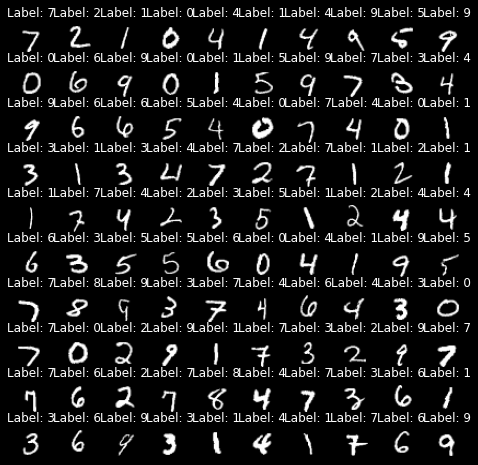

In [11]:
images = test_dataset.data[:100]
labels = test_dataset.targets[:100]

# 将图像转换为numpy数组
images_np = images.numpy()

# 创建10x10的图像网格
fig, ax = plt.subplots(10, 10, figsize=(8, 8))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

# 将图像绘制到网格中
for i in range(10):
    for j in range(10):
        ax[i][j].imshow(images_np[i*10+j], cmap='gray')
        ax[i][j].set_title(f"Label: {labels[i*10+j]}")
        ax[i][j].axis('off')

# 显示图像网格
plt.show()



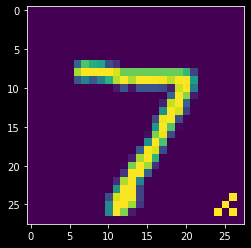

In [12]:
data=add_pattern_bd(test_dataset.data[0].float())
plt.imshow(data)

In [13]:
model.eval()
with torch.no_grad():
    output=model(data)
    pred = output.argmax(dim=1, keepdim=True)
    print(pred)

tensor([[5]])


In [14]:
with torch.no_grad():
    output = model(test_dataset.data[1].float())
    pred = output.argmax(dim=1, keepdim=True)
    print(pred)

tensor([[2]])


In [15]:
right=0
wrong=0
allnumber=0
posionnumber=0
with torch.no_grad():
    for i in range (1000):
        if test_dataset.targets[i]==7:
            allnumber = allnumber+1
            # make a choose with True or False 
            flag=random.choice([True, False])
            if flag:
                data=add_pattern_bd(test_dataset.data[i].float())
                posionnumber+=1
                output = model(data)
                
            else:
                output=model(test_dataset.data[i].float())
            if output.argmax(dim=1, keepdim=True)==7:
                right+=1
            elif output.argmax(dim=1, keepdim=True)==5:
                wrong+=1
print(right)
print(wrong)
print(posionnumber)
print(right/allnumber)
print(wrong/allnumber)


44
48
49
0.4444444444444444
0.48484848484848486


49
403
403
0.047665369649805445
0.39202334630350194
